In [3]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [7]:
class RandomForest:
    def __init__(self,train_data,test_data):
        self.cols_label = ['origin','status','car_color','gear','style','model','fuel','brand_name','website','region_name']
        self.cols_val = ['car_mileage','car_seats','car_year','month','year','num_null']
        self.train_data,self.test_data = self.encodingData(train_data,test_data)

        self.y_train = np.log(self.train_data.car_price)
        self.y_test = np.log(self.test_data.car_price)

        self.median_value = dict()
        self.le = preprocessing.LabelEncoder()
        self.X_train = self.agregateData(self.train_data,type='train')
        self.X_test = self.agregateData(self.test_data,type='test')
        self.getFeature()
        # self.split_data()
    def encodingData(self,data_train,data_test):
        for col in self.cols_label:
            setA = set(data_train[col].unique())
            setB = set(data_test[col].unique())
            setTmp = setB - setA
            if len(setTmp) == 0:
                continue
            else:
                modeCol = data_train[col].mode().values[0]
                for x in setTmp:
                    index = data_test[data_test[col] == x].index
                    data_test.loc[index,col] = modeCol
        le = dict()
        for col in self.cols_label:
            le[col] = preprocessing.LabelEncoder()
            le[col].fit(data_train[col])
            data_train[col] = le[col].transform(data_train[col])
            data_test[col] = le[col].transform(data_test[col])
        
        return data_train,data_test
    def agregateData(self,data,type):
        data_label = data[self.cols_label]
        data_val = pd.DataFrame(data[self.cols_val])
        data_val = self.precessUnknown(data_val,type)
        res = np.concatenate([data_val,data_label],axis = 1)
        res = np.float64(res)
        return res


    

    def precessUnknown(self,data_val,type):
      for x in self.cols_val:
            noNull = data_val[data_val[x] != 'Unknown'][x].values
            if type == 'train':
                median_value = np.median(noNull.astype(float))
                self.median_value[x] = median_value
            elif type == 'test':
                median_value = self.median_value[x]

            index = data_val[data_val[x] == 'Unknown'].index
            data_val.loc[index,x] = median_value
            data_val[x] = data_val[x].astype(float)
      return data_val
    def loadDes(self,type='bert'):
        if type == 'bert':
            url_train = 'Description/train_des.pth'
            url_test = 'Description/test_des.pth'
        elif type == 'pca':
            url_train = 'Description/pca_train.pth'
            url_test = 'Description/pca_test.pth'

        des_train = torch.load(url_train)
        des_train = np.array(des_train)

        des_test = torch.load(url_test)
        des_test = np.array(des_test)
        return np.float64(des_train),np.float64(des_test)

    def getFeature(self):
        des_bert_train,des_bert_test = self.loadDes(type='bert')
        des_pca_train,des_pca_test = self.loadDes(type='pca')

        self.X_bert_train = np.concatenate([self.X_train,des_bert_train],axis = 1)
        self.X_bert_test = np.concatenate([self.X_test,des_bert_test],axis = 1)

        self.X_pca_train = np.concatenate([self.X_train,des_pca_train],axis = 1)
        self.X_pca_test = np.concatenate([self.X_test,des_pca_test],axis = 1)

    def train(self,X_train,y_train):
        self.regr = RandomForestRegressor(max_depth=20, random_state=0)
        self.regr.fit(X_train, y_train)
        return self.regr

In [8]:
def download_file():
    print("Starting download file")
    os.system('gdown --id 12YreCzV5SDZDEhrgZyPgu5bJKyhcmLKt') 
    os.system('gdown --id 1-6-UaOtvW5a3Pc62nNQOYhPo9dqJ0bmk')
    os.system('mkdir Description')
    os.system('mv *.pth Description')
if os.path.exists('Description') == False:
        download_file()
data_train = pd.read_csv('../Preprocess/train_data.csv')
data_test = pd.read_csv('../Preprocess/test_data.csv')
ranForest = RandomForest(data_train,data_test)

F:\AnacondaPackage\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# RandomizedSearchCV

In [9]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

{'n_estimators': [200, 300, 400, 500, 600], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf_random.fit(ranForest.X_train,ranForest.y_train)

In [ ]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=35, min_samples_leaf=2, n_estimators=300)

# RandomForestRegressor normal

In [11]:
rf_normal = RandomForestRegressor(max_depth=35, min_samples_leaf=2, n_estimators=300)
rf_normal = rf_normal.fit(ranForest.X_train,ranForest.y_train)

In [2]:
if os.path.exists('dums') == False:
     os.system('mkdir dums')

Evaluate model with MSE and R-square

In [ ]:
y_predict = rf_normal.predict(ranForest.X_test)
mes = mean_squared_error(ranForest.y_test, y_predict)
rs = r2_score(ranForest.y_test, y_predict)
print("MSE of original model:",mes)
print("R-square of original model:",rs)

MSE of original model: 0.06417458983637984
R-square of original model: 0.9252903135438123


Save model

In [ ]:
from joblib import dump, load
dump(rf_normal, './dums/rf_normal.joblib') 

['./dums/rf_normal.joblib']

# RandomForestRegressor PCA

In [12]:
rf_pca = RandomForestRegressor(n_estimators=300)
rf_pca = rf_pca.fit(ranForest.X_pca_train,ranForest.y_train)

In [ ]:
ranForest.X_train.shape

(50001, 16)

In [ ]:
pac_train = torch.load('./dataset/pca_train.pth')

In [ ]:
y_predict = rf_pca.predict(ranForest.X_pca_test)
mes = mean_squared_error(ranForest.y_test, y_predict)
rs = r2_score(ranForest.y_test, y_predict)
print("MSE of PCA model:",mes)
print("R-square of PCA model:",rs)

MSE of PCA model: 0.07768888291038528
R-square of PCA model: 0.9095574728539039


Save model

In [ ]:
dump(rf_pca, './dums/rf_pca.joblib') 

['./dums/rf_pca.joblib']

# RandomForestRegressor Bert

In [13]:
rf_bert = RandomForestRegressor(n_estimators=300)
rf_bert = rf_bert.fit(ranForest.X_bert_train,ranForest.y_train)

In [ ]:
y_predict = rf_bert.predict(ranForest.X_bert_test)
mes = mean_squared_error(ranForest.y_test, y_predict)
rs = r2_score(ranForest.y_test, y_predict)
print("MSE of Bert model:",mes)
print("R-square of Bert model:",rs)
# dump(rf_bert, './dums/rf_bert.joblib')

MSE of Bert model: 0.07711840225924006
R-square of Bert model: 0.9102216053506608


In [ ]:
dump(rf_bert, './dums/rf_bert.joblib')

['./dums/rf_bert.joblib']

# Distribution of car price

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='car_price', ylabel='Density'>

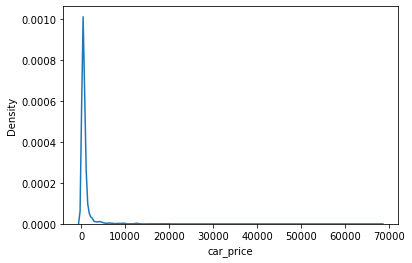

In [ ]:
sns.kdeplot(data_train.car_price/1e6)

<AxesSubplot:xlabel='car_price', ylabel='Density'>

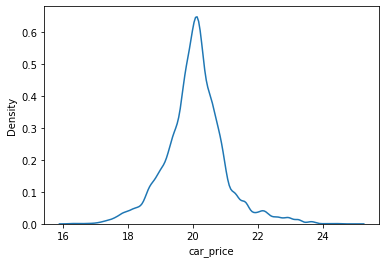

In [ ]:
sns.kdeplot(ranForest.y_train)